**FINC 430 RESEARCH PROJECT BY DALIA POBLANO**

**RESEARCH QUESTION: WHAT ARE THE STRONGEST STATISTICAL PREDICTORS OF A  STROKE?**

In [11]:
# Importing Libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from xgboost import XGBClassifier

from sklearn.inspection import permutation_importance

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Uploading Dataset
from google.colab import files
uploaded = files.upload()

Saving healthcare-dataset-stroke-data.csv to healthcare-dataset-stroke-data.csv


In [3]:
# Setting up Dataset
import pandas as pd

df = pd.read_csv(list(uploaded.keys())[0])   # loads the first uploaded file automatically
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [4]:
# Exploring the dataset's info and checking for missing values
print(df.info())
print("\nMissing values:\n", df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB
None

Missing values:
 id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_marr

In [5]:
# Impute missing BMI values
imputer = SimpleImputer(strategy="median")
df["bmi"] = imputer.fit_transform(df[["bmi"]])

In [6]:
# Drop non-informative columns
df = df.drop(columns=["id", "Residence_type", "work_type"])

In [7]:
# Encode categorical variables
categorical_cols = ["gender", "ever_married", "smoking_status"]
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

In [9]:
# Viewing head of data after cleaning
df.head()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,gender_Male,gender_Other,ever_married_Yes,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,67.0,0,1,228.69,36.6,1,True,False,True,True,False,False
1,61.0,0,0,202.21,28.1,1,False,False,True,False,True,False
2,80.0,0,1,105.92,32.5,1,True,False,True,False,True,False
3,49.0,0,0,171.23,34.4,1,False,False,True,False,False,True
4,79.0,1,0,174.12,24.0,1,False,False,True,False,True,False


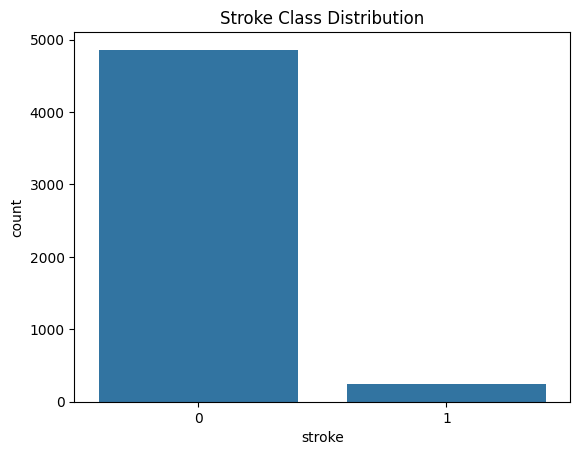

,proportion
stroke,
0,0.951272
1,0.048728


In [10]:
# Checking Class Imbalance
sns.countplot(data=df, x="stroke")
plt.title("Stroke Class Distribution")
plt.show()

df["stroke"].value_counts(normalize=True)

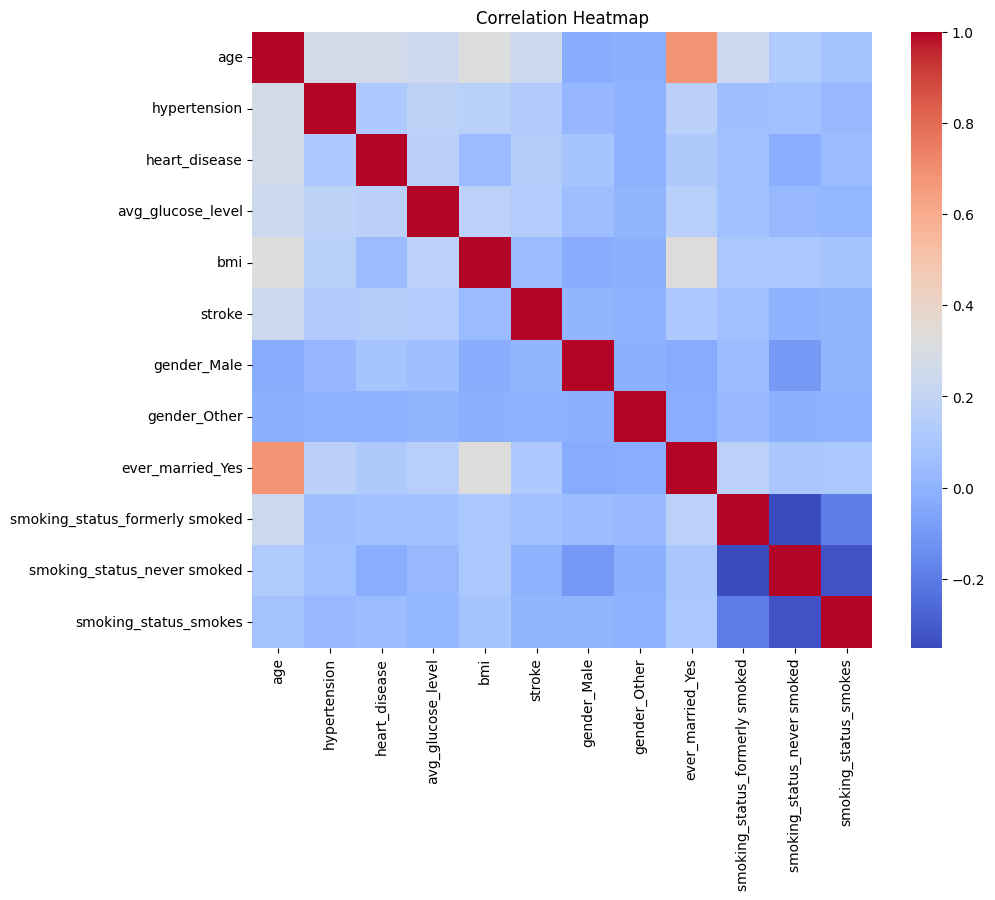

In [12]:
# Correlation heatmap
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(), annot=False, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

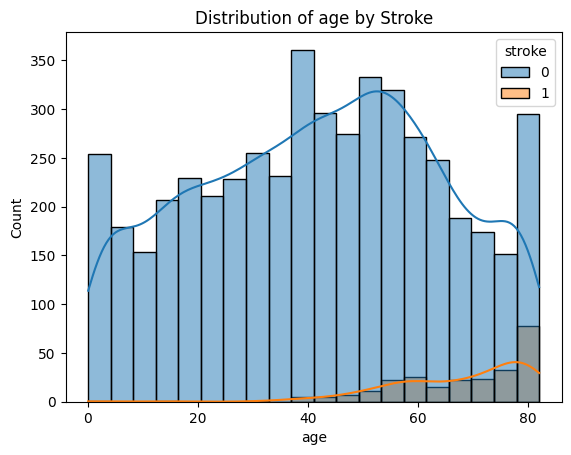

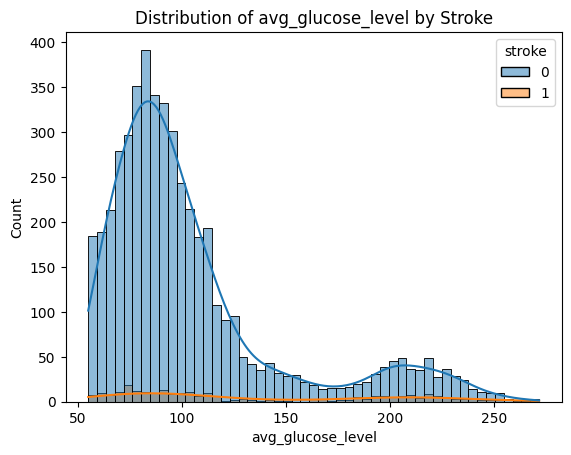

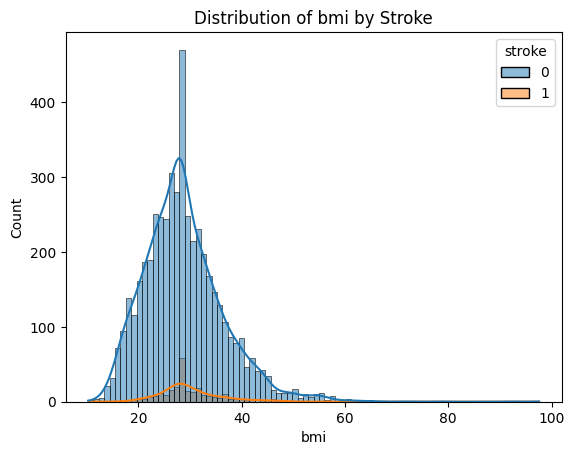

In [13]:
# Distributions
num_cols = ["age", "avg_glucose_level", "bmi"]

for col in num_cols:
    sns.histplot(data=df, x=col, hue="stroke", kde=True)
    plt.title(f"Distribution of {col} by Stroke")
    plt.show()

In [14]:
# Train and Test Split
X = df.drop("stroke", axis=1)
y = df["stroke"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [15]:
# SMOTE + SCALER + Model Pipelines
models = {
    "Logistic Regression": LogisticRegression(max_iter=500, class_weight="balanced"),
    "SVM (RBF)": SVC(kernel="rbf", probability=True, class_weight="balanced"),
    "Random Forest": RandomForestClassifier(class_weight="balanced"),
    "XGBoost": XGBClassifier(
        eval_metric="logloss",
        scale_pos_weight = y.value_counts()[0] / y.value_counts()[1]   # imbalance ratio
    ),
    "KNN": KNeighborsClassifier(),
    "Naive Bayes": GaussianNB()
}

results = {}

for name, model in models.items():

    # Build SMOTE pipeline
    pipeline = ImbPipeline(steps=[
        ("scaler", StandardScaler()),
        ("smote", SMOTE(random_state=42)),
        ("model", model)
    ])

    # Fit
    pipeline.fit(X_train, y_train)

    # Predict
    y_pred = pipeline.predict(X_test)
    y_proba = pipeline.predict_proba(X_test)[:, 1]

    # Metrics
    roc_auc = roc_auc_score(y_test, y_proba)
    report = classification_report(y_test, y_pred, output_dict=True)

    results[name] = {
        "ROC-AUC": roc_auc,
        "Precision": report["1"]["precision"],
        "Recall": report["1"]["recall"],
        "F1": report["1"]["f1-score"]
    }

In [16]:
# Basic Logistic Regression
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train_scaled, y_train)

y_pred_lr = log_reg.predict(X_test_scaled)

In [17]:
# Regularization (Lasso)
log_l1 = LogisticRegression(penalty="l1", solver="liblinear")
log_l1.fit(X_train_scaled, y_train)

LogisticRegression(penalty='l1', solver='liblinear')

In [18]:
# Regularization (Ridge)
log_l2 = LogisticRegression(penalty="l2")
log_l2.fit(X_train_scaled, y_train)

LogisticRegression()

In [19]:
# Logistic Regression Coefficients
coef_df = pd.DataFrame({
    "Feature": X.columns,
    "Coefficient": log_reg.coef_[0]
}).sort_values("Coefficient")

coef_df

,Feature,Coefficient
7,ever_married_Yes,-0.127743
9,smoking_status_never smoked,-0.043392
6,gender_Other,-0.023229
4,bmi,0.001632
5,gender_Male,0.031328
8,smoking_status_formerly smoked,0.048096
2,heart_disease,0.049218
10,smoking_status_smokes,0.089560
1,hypertension,0.134638
3,avg_glucose_level,0.181822


**MACHINE LEARNING MODELS**


In [20]:
# Function to Evaluate Models
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:,1] if hasattr(model, "predict_proba") else None

    return {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1": f1_score(y_test, y_pred),
        "AUC": roc_auc_score(y_test, y_prob) if y_prob is not None else None
    }

In [21]:
# KNN
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_scaled, y_train)

KNeighborsClassifier()

In [22]:
# Naive Bayes
nb = GaussianNB()
nb.fit(X_train_scaled, y_train)

GaussianNB()

In [23]:
# SVM Linear + RBF
svm_linear = SVC(kernel="linear", probability=True)
svm_linear.fit(X_train_scaled, y_train)

svm_rbf = SVC(kernel="rbf", probability=True)
svm_rbf.fit(X_train_scaled, y_train)

SVC(probability=True)

In [24]:
# Decision Tree
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

DecisionTreeClassifier()

In [25]:
# Random Forest
rf = RandomForestClassifier(n_estimators=300)
rf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=300)

In [26]:
# XGBoost
xgb = XGBClassifier(eval_metric="logloss")
xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

In [33]:
# Model Performance Comparison
models = {
    "Logistic Regression": log_reg,
    "KNN": knn,
    "Naive Bayes": nb,
    "SVM Linear": svm_linear,
    "SVM RBF": svm_rbf,
    "Decision Tree": dt,
    "Random Forest": rf,
    "XGBoost": xgb
}

results = {}

for name, model in models.items():
    results[name] = evaluate_model(model, X_test_scaled if name.startswith("SVM") or name=="KNN" or name=="Naive Bayes" else X_test, y_test)

pd.DataFrame(results).T


,Accuracy,Precision,Recall,F1,AUC
Logistic Regression,0.048924,0.048924,1.00,0.093284,0.563981
KNN,0.948141,0.200000,0.02,0.036364,0.626739
Naive Bayes,0.345401,0.068340,0.98,0.127771,0.801296
SVM Linear,0.951076,0.000000,0.00,0.000000,0.515720
SVM RBF,0.951076,0.000000,0.00,0.000000,0.662716
Decision Tree,0.909002,0.169231,0.22,0.191304,0.582222
Random Forest,0.947162,0.000000,0.00,0.000000,0.813683
XGBoost,0.945205,0.312500,0.10,0.151515,0.805885


**FEATURE IMPORTANCE AND INTERPRETATION**

In [28]:
# Random Forest Feature Importance
rf_importance = pd.DataFrame({
    "Feature": X.columns,
    "Importance": rf.feature_importances_
}).sort_values("Importance", ascending=False)

rf_importance

,Feature,Importance
3,avg_glucose_level,3.169036e-01
4,bmi,2.634034e-01
0,age,2.556072e-01
5,gender_Male,3.059829e-02
1,hypertension,2.756304e-02
9,smoking_status_never smoked,2.351487e-02
2,heart_disease,2.265223e-02
8,smoking_status_formerly smoked,2.057726e-02
7,ever_married_Yes,2.011207e-02
10,smoking_status_smokes,1.906743e-02


In [34]:
# XGBoost Feature Importance
xgb_importance = pd.DataFrame({
    "Feature": X.columns,
    "Importance": xgb.feature_importances_
}).sort_values("Importance", ascending=False)

xgb_importance

,Feature,Importance
0,age,0.185559
2,heart_disease,0.128700
7,ever_married_Yes,0.128021
1,hypertension,0.111243
4,bmi,0.081208
3,avg_glucose_level,0.078911
10,smoking_status_smokes,0.074723
9,smoking_status_never smoked,0.074143
8,smoking_status_formerly smoked,0.070028
5,gender_Male,0.067464
